## RF. Performance assessment.


## Import Libraries:

In [34]:
import numpy as np
import pandas as pd
import datetime
from pathlib import Path

import pickle

import sys
sys.path.append( '..')


In [35]:
ff = 'GCL' # 'RNFL' # 'GCL'
visit = 'All' # 'Left', 'Right'
test_f = '../TestSubjects/PPole/test_9.txt'

In [36]:
df = pd.read_csv( '../../Bases_Datos_Tabulares_Elena_Nov2022/BaseDatos_PPole_EM_2020.csv' )    

In [37]:
# Count

def count( df, g ):
    
    dfb = df.copy()
    
    df = df[df['GRUPO (0=Sano, 1=EM)'] == g]
    df = df[df['OJO (D=1, I=2)']== 1]

    print( 'R')

    print(df.shape)
    print(df.groupby('APELLIDOS').head(1).shape)

    df = dfb
    
    df = df[df['GRUPO (0=Sano, 1=EM)'] == g]
    df = df[df['OJO (D=1, I=2)']== 2]


    print( 'L')

    print(df.shape)
    print(df.groupby('APELLIDOS').head(1).shape)

In [38]:
count(df, 0)
count(df, 1)

R
(34, 159)
(32, 159)
L
(32, 159)
(31, 159)
R
(50, 159)
(46, 159)
L
(50, 159)
(47, 159)


In [39]:
import re

def RNFL_features(df, features):
    
    regex = re.compile( 'Mean [0-9].[0-9] RNFL' )
    filtered = [f for f in features if regex.match(f)]

    for f in filtered:
        df[f] = pd.to_numeric(df[f], errors='coerce')
        
    print(df.shape)

    df = df.dropna(subset = filtered, how = 'all') 

    df = df.fillna(0)

    print(df.shape)

    return df, filtered


def GCL_features(df, features):
    
    regex = re.compile( 'Mean [0-9].[0-9] GCL' )
    filtered = [f for f in features if regex.match(f)]

    for f in filtered:
        df[f] = pd.to_numeric(df[f], errors='coerce')
        
    print(df.shape)

    df = df.dropna(subset = filtered, how = 'all') 

    df = df.fillna(0)

    print(df.shape)

    return df, filtered

In [40]:
features = df.keys()

if ff == 'RNFL':
    df, filtered = RNFL_features(df, features)
elif ff == 'GCL':    
    df, filtered = GCL_features(df, features)


(166, 159)
(166, 159)


In [41]:
count(df, 0)
count(df, 1)

R
(34, 159)
(32, 159)
L
(32, 159)
(31, 159)
R
(50, 159)
(46, 159)
L
(50, 159)
(47, 159)


In [42]:
sanos = df 
sanos = sanos[sanos['GRUPO (0=Sano, 1=EM)'] == 0]

em = df 
em = em[em['GRUPO (0=Sano, 1=EM)'] == 1]

In [43]:
#  reading the file
test_subjects = pd.read_csv(test_f, header = None)

In [44]:
from random import randint

import itertools

# Todos los pacientes, todos los ojos
# Patient leakage

def select_train_test( df, test_subjects ):

    patients = df['APELLIDOS'].unique()

    indexes = []
    
    for p in patients:
        
        if p not in test_subjects.values:
            
            record = df[df['APELLIDOS'] == p]
        
            indexes.append(record.index.values)
            
    train = df.loc[list(itertools.chain(*indexes))]
    
    indexes = []

    for p in patients:
        
        if p in test_subjects.values:
        
            record = df[df['APELLIDOS'] == p]
        
            indexes.append(record.index.values)
    
    test = df.loc[list(itertools.chain(*indexes))]
    
    return train, test


In [45]:
# One patient, one eye, no data leakage
"""
em_train, em_test = select_train_test_bl_both_eyes(em, test_subjects)
sanos_train, sanos_test = select_train_test_bl_both_eyes(sanos, test_subjects)
"""

em_train, em_test = select_train_test(em, test_subjects)
print( "-------------------------")
sanos_train, sanos_test = select_train_test(sanos, test_subjects)

print(em_train.shape)
print(sanos_train.shape)

print(em_test.shape)
print(sanos_test.shape)

-------------------------
(83, 159)
(48, 159)
(17, 159)
(18, 159)


In [46]:
filtered = list(filtered) # + ['Lastname']

In [47]:
em_train = em_train[filtered]
sanos_train = sanos_train[filtered]

em_test = em_test[filtered]
sanos_test = sanos_test[filtered]

em_train['Diagnosis'] = 1
sanos_train['Diagnosis'] = 0

em_test['Diagnosis'] = 1
sanos_test['Diagnosis'] = 0


In [48]:
df = em_train.append(sanos_train)

y_train = df['Diagnosis']
train = df.drop('Diagnosis', axis=1)

df = em_test.append(sanos_test)

y_test = df['Diagnosis']
test = df.drop('Diagnosis', axis=1)

# Balancing

In [49]:
"""
from sklearn.model_selection import train_test_split

train, test, y_train, y_test = train_test_split( X, y, test_size = 0.20 ) # , random_state=42)
"""
import imblearn
print(imblearn.__version__)

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


# transform the dataset
counter = Counter(y_train)
print(counter)

oversample = SMOTE()
train, y_train = oversample.fit_resample(train, y_train)

counter = Counter(y_train)
print(counter)


"""

# Undersampling

from imblearn.under_sampling import RandomUnderSampler

counter = Counter(y_train)
print(counter)

rus = RandomUnderSampler(random_state=0)

train, y_train = rus.fit_resample(train, y_train)

counter = Counter(y_train)
print(counter)

"""

0.8.1
Counter({1: 83, 0: 48})
Counter({1: 83, 0: 83})


'\n\n# Undersampling\n\nfrom imblearn.under_sampling import RandomUnderSampler\n\ncounter = Counter(y_train)\nprint(counter)\n\nrus = RandomUnderSampler(random_state=0)\n\ntrain, y_train = rus.fit_resample(train, y_train)\n\ncounter = Counter(y_train)\nprint(counter)\n\n'

In [50]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit( train, y_train )


RandomForestClassifier()

In [51]:
classification = model.predict_proba(test)


In [69]:
type(classification[0][0])

numpy.float64

In [70]:
test

Mean 1.1 GCL  Mean 1.2 GCL  Mean 1.3 GCL  Mean 1.4 GCL  Mean 2.1 GCL  \
76           23.0            25            28            25            24   
77           23.0            24            26            32            25   
80           17.0            18            21            23            22   
92           22.0            25            22            22            25   
100          20.0            21            22            23            23   
112          22.0            23            22            24            26   
113          21.0            23            23            24            25   
125          21.0            23            25            21            17   
130          20.0            20            23            24            21   
131          19.0            22            23            24            22   
145          22.0            24            23            25            25   
146          24.0            24            23            24            24   
147          19.0            18            19            22            16   
148          23.0            25            26            28            25   
152          21.0            21            24            23            24   
153          17.0            18            19            20            18   
161          21.0            23            23            21            23   
6            23.0            25            25            26            27   
7            24.0            24            27            26            27   
11           20.0            22            22            22            23   
12           21.0            21            21            22            23   
17           22.0            23            24            24            23   
18           22.0            24            24            25            27   
21           23.0            22            26            23            21   
22           21.0            20            21            20            22   
29           22.0            23            25            28            27   
30           22.0            22            27            26            25   
64           22.0            24            27            28            25   
65           21.0            22            25            25            25   
41           22.0            26            25            27            26   
42           24.0            26            26            25            25   
43           26.0            27            29            30            29   
44           22.0            24            25            25            25   
55           25.0            23            26            28            25   
56           24.0            24            25            27            25   

     Mean 2.2 GCL  Mean 2.3 GCL  Mean 2.4 GCL  Mean 3.1 GCL  Mean 3.2 GCL  \
76             28            32            34            27            33   
77             27            30            35            27            33   
80             24            28            34            26            32   
92             26            28            29            26            34   
100            26            29            31            28            35   
112            29            33            36            31            37   
113            27            28            31            26            35   
125            18            20            21            20            23   
130            25            27            31            24            29   
131            25            29            30            24            29   
145            25            29            34            25            31   
146            25            29            32            27            34   
147            18            23            30            27            33   
148            28            33            36            30            36   
152            25            26            27            24            26   


In [52]:
ntest = test.shape[0]
hardEstimClass = -1 * np.ones(ntest, int)

for s in range(ntest):
    hardEstimClass[s] = np.argmax([classification[s][0], classification[s][1]])
    

In [53]:
def calcBCA(estimLabels, trueLabels, nrClasses):
    # Balanced Classification Accuracy

    bcaAll = []
    for c0 in range(nrClasses):
        # c0 can be either CTL, MCI or AD

        # one example when c0=CTL
        # TP - label was estimated as CTL, and the true label was also CTL
        # FP - label was estimated as CTL, but the true label was not CTL (was either MCI or AD).
        TP = np.sum((estimLabels == c0) & (trueLabels == c0))
        TN = np.sum((estimLabels != c0) & (trueLabels != c0))
        FP = np.sum((estimLabels == c0) & (trueLabels != c0))
        FN = np.sum((estimLabels != c0) & (trueLabels == c0))

        # sometimes the sensitivity of specificity can be NaN, if the user doesn't forecast one of the classes.
        # In this case we assume a default value for sensitivity/specificity
        if (TP+FN) == 0:
            sensitivity = 0.5
        else:
            sensitivity = (1. * TP)/(TP+FN)

        if (TN+FP) == 0:
            specificity = 0.5
        else:
            specificity = (1. * TN)/(TN+FP)
      
        if (TN + TP + FN + FP) == 0:   
            accuracy = 0.0
        else:
            accuracy = (1. * TN + 1.0 * TP ) / (TN + TP + FN + FP )  

        bcaCurr = 0.5*(sensitivity+specificity)
        bcaAll += [bcaCurr]
        print('Class %d bcaCurr %f TP %f TN %f FP %f FN %f acc %f sens %f spec %f' % (c0, bcaCurr, TP, TN, FP, FN, accuracy, sensitivity, specificity))

    return np.mean(bcaAll)

In [54]:
calcBCA(hardEstimClass, y_test, 2)

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(hardEstimClass, y_test, [0, 1])
print( conf )

Class 0 bcaCurr 0.736928 TP 17.000000 TN 9.000000 FP 8.000000 FN 1.000000 acc 0.742857 sens 0.944444 spec 0.529412
Class 1 bcaCurr 0.736928 TP 9.000000 TN 17.000000 FP 1.000000 FN 8.000000 acc 0.742857 sens 0.529412 spec 0.944444
[[17  8]
 [ 1  9]]


Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


## SHAP

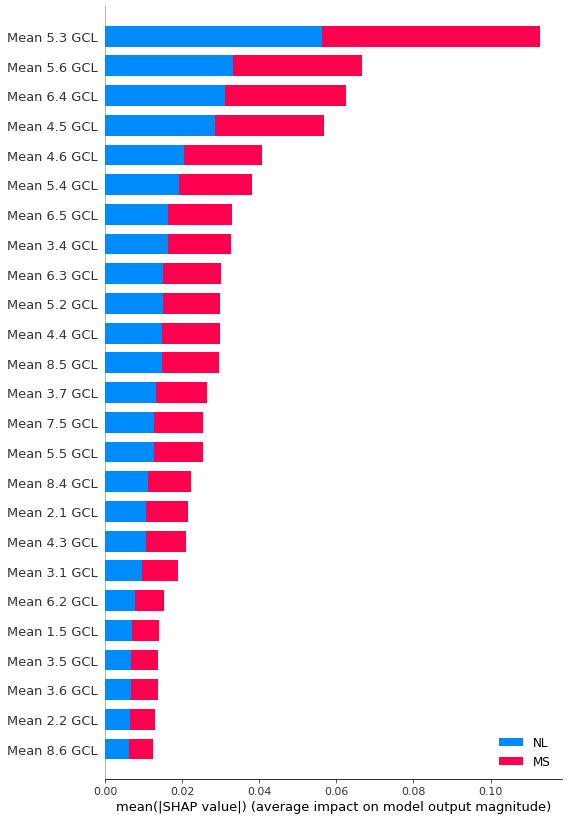

In [55]:
import shap
import matplotlib.pyplot as plt

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

test_df = test
          
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_df)

"""
# df = pd.DataFrame( np.abs(np.mean(np.abs(shap_values), axis = 0)).T, test_df.keys() )

# df = pd.DataFrame( np.abs(shap_values).T, test_df.keys() )

df = pd.DataFrame( np.mean(np.abs(shap_values), axis = 0), test_df.keys() )
"""

df = pd.DataFrame( np.abs(np.mean(np.abs(shap_values), axis = 0)).T, test_df.keys() )

dfg = df.copy()

df = df.sort_values([0])

# df = df.iloc[-25::]

h = list(df.index.values)

for i in range(len(h)):
    k = h[i]
    kn = k[0:min(25,len(k))]
    # print(kn)
    
    test_df = test_df.rename(columns={k: kn})
    
#    test_df.columns.values[i] = k
    
    # test_df.columns.values[i] = '%d' % i + "-" + k
    # test_df.columns.values[i] = k + "-" + '%d' % i

shap.summary_plot(shap_values, test_df.keys(), plot_type="bar", max_display = 25, class_names = ['NL', 'MS'], show = False)

# pltname = './EMCEBImputation'+ "/" + "XGB_" + fname + "_Summary_Plot.png"
# plt.savefig( pltname, bbox_inches='tight')


In [56]:
dfg = dfg.sort_index()

dfg1 = dfg.values

m = np.reshape(dfg1, (8, 8), order='F')

ValueError: cannot reshape array of size 2240 into shape (8,8)

In [ ]:
from matplotlib import pyplot as plt
# fig = plt.imshow(m, interpolation='nearest')
pos = plt.imshow(np.abs(m), cmap='Blues', interpolation='none')
plt.show()

# 5.3. Esta mal reconstruida en el eje de las y 

In [ ]:
df

In [ ]:
len(shap_values[0][0][0])

In [58]:
shap_values

[array([[ 0.00423368,  0.00256155, -0.00600368, ..., -0.001034  ,
         -0.00533416, -0.00553363],
        [-0.00056459,  0.00367496, -0.00666575, ..., -0.01968872,
         -0.00499731, -0.00350219],
        [-0.00152598, -0.01295643,  0.00078904, ...,  0.00196949,
          0.00905097,  0.00093052],
        ...,
        [-0.00080383,  0.00254347,  0.00054968, ...,  0.00068366,
         -0.00683992,  0.00247269],
        [ 0.00814378,  0.00152943, -0.00942169, ..., -0.02578745,
         -0.0033666 , -0.00603604],
        [ 0.01380362,  0.00228742, -0.0011133 , ..., -0.0265806 ,
         -0.00753776, -0.00760423]]),
 array([[-0.00423368, -0.00256155,  0.00600368, ...,  0.001034  ,
          0.00533416,  0.00553363],
        [ 0.00056459, -0.00367496,  0.00666575, ...,  0.01968872,
          0.00499731,  0.00350219],
        [ 0.00152598,  0.01295643, -0.00078904, ..., -0.00196949,
         -0.00905097, -0.00093052],
        ...,
        [ 0.00080383, -0.00254347, -0.00054968, ..., -